In [96]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers

In [180]:
class MLP(layers.Layer):
    def __init__(self, outsize, hidden_size=None):
        super().__init__()
        hidden_size = hidden_size if hidden_size else outsize
        self.layer_1 = layers.Dense(hidden_size, activation=tf.nn.gelu)
        self.layer_2 = layers.Dense(outsize)

    def call(self, inputs):
        h = self.layer_1(inputs)
        return self.layer_2(h)

class Mixer(layers.Layer):
    def __init__(self, outheight, outwidth, Net=MLP):
        super().__init__()
        self.layer_1 = Net(outheight)
        self.layer_2 = Net(outwidth)

    def call(self, inputs):
        h = tf.transpose(inputs, [0, 2, 1])
        h = self.layer_1(h)
        h = tf.transpose(h, [0, 2, 1])
        return self.layer_2(h)

class ScalarGate(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.value = tf.Variable(0.0, trainable=True)

    def call(self, inputs):
        return self.value * inputs

def MixerLayers(height, width, num_mix_layers, Net=MLP, name=None):
    inputs = tf.keras.layers.Input(shape=(height, width))
    h = inputs
    for i in range(num_mix_layers):
        mixed = Mixer(height, width)(h)
        h = ScalarGate()(mixed) + h
    return tf.keras.Model(inputs=inputs, outputs=h, name=name)

def RowColClf(height, width, num_classes, Net=MLP, name=None):
    "Rather than average pooling, use MLP for rows, cols, then concat."
    inputs = tf.keras.layers.Input(shape=(height, width))
    rows_out = Net(1)(inputs)
    rows_out = tf.keras.layers.Lambda(lambda x: x[:, :, 0])(rows_out)
    cols_out = tf.keras.layers.Permute([2, 1])(inputs)
    cols_out = Net(1)(cols_out)
    cols_out = tf.keras.layers.Lambda(lambda x: x[:, :, 0])(cols_out)
    concat = tf.keras.layers.Concatenate()([rows_out, cols_out])
    flat = tf.keras.layers.Flatten()(concat)
    y = tf.keras.layers.Dense(num_classes)(flat)
    return tf.keras.Model(inputs=inputs, outputs=y, name=name)

def mixer_classifier(height, width, num_mix_layers, num_classes, Net=MLP, name=None):
    inputs = tf.keras.layers.Input(shape=(height, width))
    h = MixerLayers(height, width, num_mix_layers, Net)(inputs)
    h = RowColClf(height, width, num_classes, Net)(h)
    return tf.keras.Model(inputs=inputs, outputs=h, name=name)

def autoencoder(height, width, num_classes, num_mix_layers, name=None):
    """Autoencoder via mixer layers. Note, skip connections aren't used here, 
    otherwise network is trivially the identity function."""
    inputs = tf.keras.layers.Input(shape=(height, width))
    h = inputs
    for i in range(num_mix_layers):
        h = Mixer(height, width)(h)
    return tf.keras.Model(inputs=inputs, outputs=h, name=name)


# MNIST

In [164]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, test_images = train_images.astype(np.float32), test_images.astype(np.float32)

height, width = train_images.shape[-2:]
num_classes = 10

## Classifier

Model: "model_140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_145 (InputLayer)       [(None, 28, 28)]          0         
_________________________________________________________________
model_138 (Functional)       (None, 28, 28)            12996     
_________________________________________________________________
model_139 (Functional)       (None, 10)                632       
Total params: 13,628
Trainable params: 13,628
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
938/938 [==============================] - 12s 10ms/step - loss: 0.9065 - accuracy: 0.7009 - val_loss: 0.1684 - val_accuracy: 0.9484
Epoch 2/10
938/938 [==============================] - 9s 10ms/step - loss: 0.1718 - accuracy: 0.9482 - val_loss: 0.1248 - val_accuracy: 0.9609
Epoch 3/10
938/938 [==============================] - 9s 10ms/step - loss: 0.1188 - accurac

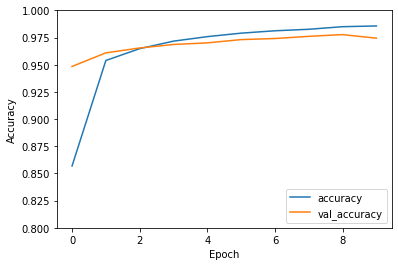

In [141]:
num_mix_layers = 8

inputs = tf.keras.layers.Input(shape=(height, width))
mixer_layers = MixerLayers(height, width, num_mix_layers)(inputs)
clf = RowColClf(height, width, num_classes)(mixer_layers)
model = tf.keras.Model(inputs=inputs, outputs=clf)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.8, 1])
plt.legend(loc='lower right')

mixfunc = tf.keras.backend.function([inputs], [mixer_layers])
for i in range(5):
    im = train_images[i:i+1,:,:]

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,:,:], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(mixfunc(im)[0][0,:,:], cmap='gray')
    plt.axis('off')
    plt.title(f'Representation {i}')

plt.suptitle("Final hidden representation")
plt.tight_layout()
plt.show()

Model: "model_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_150 (InputLayer)       [(None, 28, 28)]          0         
_________________________________________________________________
mixer_462 (Mixer)            (None, 8, 8)              464       
_________________________________________________________________
model_143 (Functional)       (None, 8, 8)              4624      
_________________________________________________________________
model_144 (Functional)       (None, 10)                192       
Total params: 5,280
Trainable params: 5,280
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
938/938 [==============================] - 36s 30ms/step - loss: 1.3237 - accuracy: 0.5412 - val_loss: 0.2888 - val_accuracy: 0.9168
Epoch 2/10
938/938 [==============================] - 26s 28ms/step - loss: 0.2788 - accuracy: 0.9184 - 

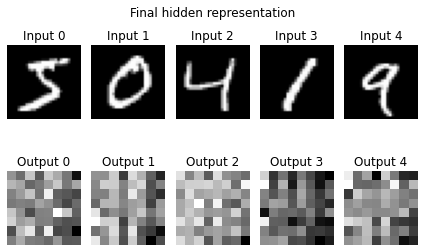

In [144]:
"With linear mixer to modify the size of the hidden representation (and therefore MLP size)."
num_mix_layers = 8
hidden_size = 8  # used as height & width. Can be smaller or larger than original image.

inputs = tf.keras.layers.Input(shape=(height, width))
mapped = Mixer(hidden_size, hidden_size, layers.Dense)(inputs)
mixer_layers = MixerLayers(hidden_size, hidden_size, num_mix_layers)(mapped)
clf = RowColClf(hidden_size, hidden_size, num_classes)(mixer_layers)
model = tf.keras.Model(inputs=inputs, outputs=clf)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.8, 1])
plt.legend(loc='lower right')

mixfunc = tf.keras.backend.function([inputs], [mixer_layers])
for i in range(5):
    im = train_images[i:i+1,:,:]

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,:,:], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(mixfunc(im)[0][0,:,:], cmap='gray')
    plt.axis('off')
    plt.title(f'Representation {i}')

plt.suptitle("Final hidden representation")
plt.tight_layout()
plt.show()

Model: "model_230"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_198 (InputLayer)       [(None, 28, 28)]          0         
_________________________________________________________________
mixer_562 (Mixer)            (None, 4, 4)              232       
_________________________________________________________________
model_228 (Functional)       (None, 4, 4)              73800     
_________________________________________________________________
model_229 (Functional)       (None, 10)                6236      
Total params: 80,268
Trainable params: 80,268
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
938/938 [==============================] - 21s 17ms/step - loss: 1.2213 - accuracy: 0.5883 - val_loss: 0.3432 - val_accuracy: 0.8958
Epoch 2/10
938/938 [==============================] - 15s 16ms/step - loss: 0.3407 - accuracy: 0.8960 

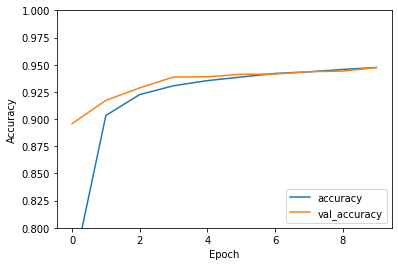

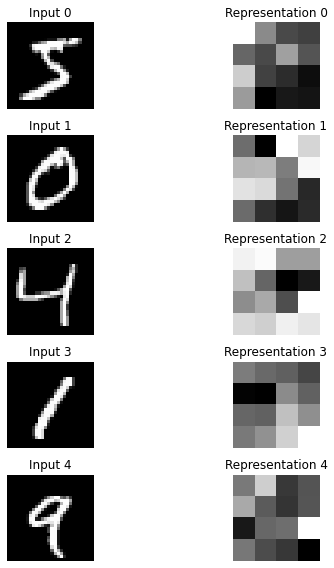

In [192]:
"With linear mixer to modify the size of the hidden representation (and therefore MLP size)."
num_mix_layers = 8
hidden_size = 4  # used as height & width. Can be smaller or larger than original image.

inputs = tf.keras.layers.Input(shape=(height, width))
mapped = Mixer(hidden_size, hidden_size, layers.Dense)(inputs)
mixer_layers = MixerLayers(hidden_size, hidden_size, num_mix_layers)(mapped)
clf = RowColClf(hidden_size, hidden_size, num_classes)(mixer_layers)
model = tf.keras.Model(inputs=inputs, outputs=clf)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.8, 1])
plt.legend(loc='lower right')

plt.figure(figsize=(8, 8))
mixfunc = tf.keras.backend.function([inputs], [mixer_layers])
for i in range(5):
    im = train_images[i:i+1,...]

    plt.subplot(5, 2, i*2+1)
    plt.imshow(im[0, ...], vmin=0, vmax=1, cmap='gray')
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(5, 2, i*2+2)
    plt.imshow(mixfunc(im)[0][0,...], cmap='gray')
    plt.axis('off')
    plt.title(f'Representation {i}')

plt.tight_layout()
plt.show()

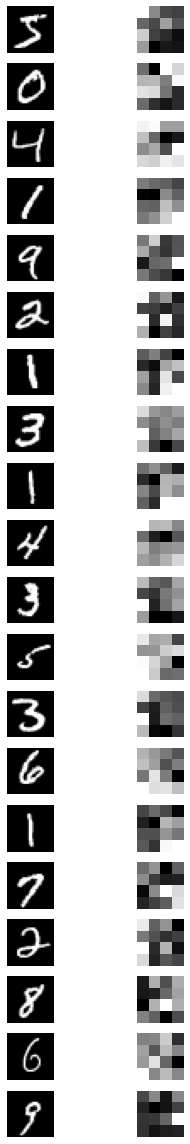

In [194]:
plt.figure(figsize=(5, 16))
mixfunc = tf.keras.backend.function([inputs], [mixer_layers])
for i in range(20):
    im = train_images[i:i+1,...]

    plt.subplot(20, 2, i*2+1)
    plt.imshow(im[0, ...], vmin=0, vmax=1, cmap='gray')
    plt.axis('off')

    plt.subplot(20, 2, i*2+2)
    plt.imshow(mixfunc(im)[0][0,...], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

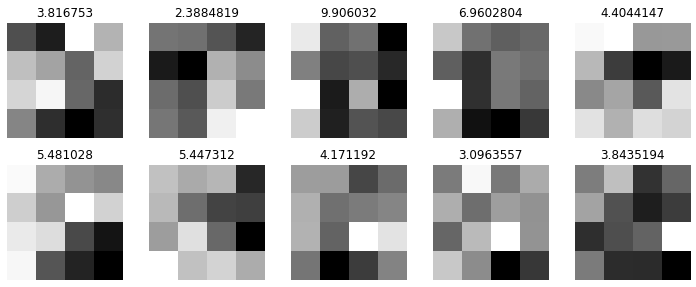

In [225]:
"Average representations per class."

avgs = []
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    representations = mixfunc(train_images[train_labels==i,...])[0]
    av = np.mean(representations, axis=0)
    plt.title(np.std(representations))
    plt.imshow(av, cmap='gray')

    avgs.append(av)
    plt.axis('off')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Class')

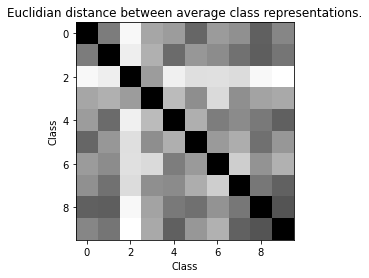

In [226]:
avgs_np = np.stack(avgs).reshape(10, -1)
diffs = (avgs_np.reshape(10, -1, 16) - avgs_np.reshape(-1, 10, 16))**2
diffs = np.sqrt(np.mean(diffs, axis=-1))
plt.imshow(diffs, cmap='gray')
plt.title('Euclidian distance between average class representations.')
plt.xlabel('Class')
plt.ylabel('Class')

## Autoencoder

Note that skip connections are removed for the autoencoder model, because they would cause the model to be initialised as the identity function, (due to the initial 0 scalar gate), which would make the model trivially an autoencoder.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
mixer_16 (Mixer)             (None, 28, 28)            3248      
_________________________________________________________________
mixer_17 (Mixer)             (None, 28, 28)            3248      
Total params: 6,496
Trainable params: 6,496
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
938/938 [==============================] - 6s 5ms/step - loss: 0.0357 - root_mean_squared_error: 0.1813 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0530
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 3/10
938/938 [==================

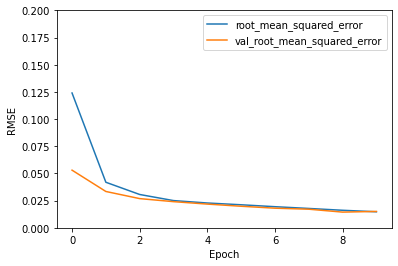

In [ ]:
num_mix_layers = 2
model = autoencoder(height, width, num_classes, num_mix_layers)
print(model.summary())

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_images, train_images, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_images))

# PLOTS
plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim([0, .2])
plt.legend()
test_loss, test_acc = model.evaluate(test_images,  test_images, verbose=2)

for i in range(5):
    im = train_images[i:i+1,:,:]

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,:,:], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(model.predict(im)[0,:,:], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Output {i}')

plt.suptitle("Autoencoder results")
plt.tight_layout()
plt.show()

# CIFAR-10

In [145]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, test_images = train_images.astype(np.float32), test_images.astype(np.float32)
height, width, channels = 32, 32, 3
num_classes = 10

## Classifier

Model: "model_179"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_171 (InputLayer)       [(None, 32, 32)]          0         
_________________________________________________________________
model_177 (Functional)       (None, 32, 32)            67600     
_________________________________________________________________
model_178 (Functional)       (None, 10)                720       
Total params: 68,320
Trainable params: 68,320
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 34s 34ms/step - loss: 2.1481 - accuracy: 0.2090 - val_loss: 1.8351 - val_accuracy: 0.3342
Epoch 2/10
782/782 [==============================] - 25s 31ms/step - loss: 1.7744 - accuracy: 0.3655 - val_loss: 1.6670 - val_accuracy: 0.4004
Epoch 3/10
782/782 [==============================] - 25s 31ms/step - loss: 1.6253 - accur

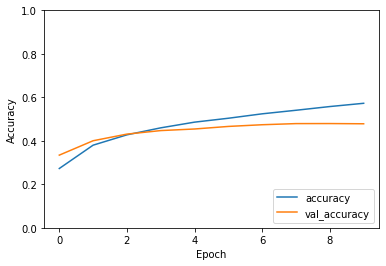

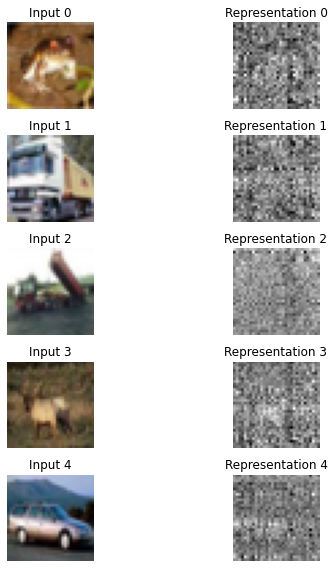

In [162]:
num_mix_layers = 16

inputs = tf.keras.layers.Input(shape=(height, width))
mixer_layers = MixerLayers(height, width, num_mix_layers)(inputs)
clf = RowColClf(height, width, num_classes)(mixer_layers)
model = tf.keras.Model(inputs=inputs, outputs=clf)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images[:,:,:,0], train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images[:,:,:,0], test_labels))

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.figure(figsize=(8, 8))
mixfunc = tf.keras.backend.function([inputs], [mixer_layers])
for i in range(5):
    im = train_images[i:i+1,...]

    plt.subplot(5, 2, i*2+1)
    plt.imshow(im[0, ...], vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(5, 2, i*2+2)
    plt.imshow(mixfunc(im[:,:,:,0])[0][0,...], cmap='gray')
    plt.axis('off')
    plt.title(f'Representation {i}')

plt.tight_layout()
plt.show()

In [ ]:
num_mix_layers = 32

inputs = tf.keras.layers.Input(shape=(height, width, channels))
reshaped = tf.keras.layers.Reshape([height, width * channels])(inputs)
model = mixer_model(height, width * channels, num_classes, num_mix_layers)(reshaped)
model = tf.keras.Model(inputs=inputs, outputs=model)
print(model.summary())

model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 32, 96)            0         
_________________________________________________________________
model_26 (Functional)        (None, 10)                665008    
Total params: 665,008
Trainable params: 665,008
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 69s 69ms/step - loss: 1.8674 - accuracy: 0.3184 - val_loss: 1.3868 - val_accuracy: 0.5045
Epoch 2/10
782/782 [==============================] - 50s 64ms/step - loss: 1.3272 - accuracy: 0.5250 - val_loss: 1.2248 - val_accuracy: 0.5651
Epoch 3/10
782/782 [==============================] - 50s 64ms/step - loss: 1.1355 - accu

KeyboardInterrupt: ignored

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 32, 96)            0         
_________________________________________________________________
mixer_140 (Mixer)            (None, 256, 256)          33280     
_________________________________________________________________
model_25 (Functional)        (None, 10)                1058324   
Total params: 1,091,604
Trainable params: 1,091,604
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 39s 47ms/step - loss: 1.8530 - accuracy: 0.3246 - val_loss: 1.4987 - val_accuracy: 0.4716
Epoch 2/10
782/782 [==============================] - 36s 46ms/step - loss: 1.3029 - accuracy: 0.

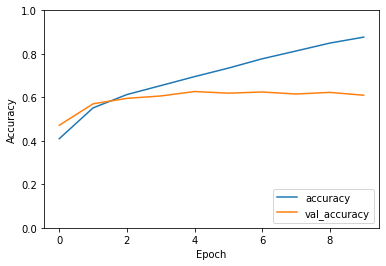

In [ ]:
"With linear mapping to modify the size of the hidden representation (and therefore MLP size)."
num_mix_layers = 4
hidden_size = 256

inputs = tf.keras.layers.Input(shape=(height, width, channels))
reshaped = tf.keras.layers.Reshape([height, width * channels])(inputs)
h = Mixer(hidden_size, hidden_size, layers.Dense)(reshaped)  # linear map to hidden size
h = mixer_model(hidden_size, hidden_size, num_classes, num_mix_layers)(h)
model = tf.keras.Model(inputs=inputs, outputs=h)
print(model.summary())

model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

## Autoencoder

Note that skip connections are removed for the autoencoder model, because they would cause the model to be initialised as the identity function, (due to the initial 0 scalar gate), which would make the model trivially an autoencoder.

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 96)            0         
_________________________________________________________________
model_4 (Functional)         (None, 32, 96)            41472     
_________________________________________________________________
reshape_2 (Reshape)          (None, 32, 32, 3)         0         
Total params: 41,472
Trainable params: 41,472
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 7s 7ms/step - loss: 0.0494 - root_mean_squared_error: 0.2086 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0706
Epoch 2/10
782/782 [==============================] - 5s 7ms/step - loss: 0.

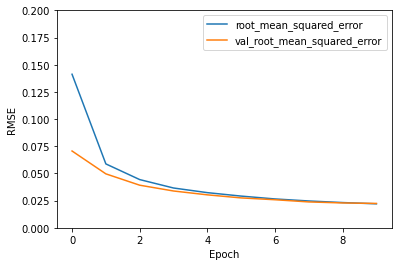

In [ ]:
num_mix_layers = 2

inputs = tf.keras.layers.Input(shape=(height, width, channels))
reshaped = tf.keras.layers.Reshape([height, width * channels])(inputs)
model = autoencoder(height, width * channels, num_classes, num_mix_layers)(reshaped)
model = tf.keras.layers.Reshape([height, width, channels])(model)
model = tf.keras.Model(inputs=inputs, outputs=model)
print(model.summary())

model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_images[:50000,...], train_images[:50000,...], batch_size=64, epochs=10, 
                    validation_data=(test_images, test_images))

plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim([0, .2])
plt.legend()
test_loss, test_acc = model.evaluate(test_images,  test_images, verbose=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


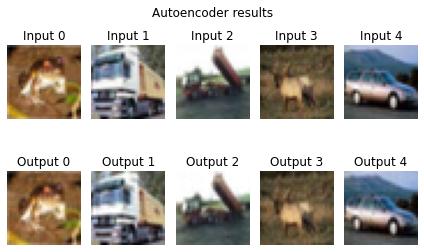

In [ ]:
for i in range(5):
    im = train_images[i:i+1,:,:]

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,:,:], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(model.predict(im)[0,:,:], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Output {i}')

plt.suptitle("Autoencoder results")
plt.tight_layout()
plt.show()